# Test Kepler

Notebook that test Kepler construction for 15 minute cities visualizations

## Import modules

In [1]:
import io
import os
import sys

import boto3
import geopandas as gpd
import pandas as pd
from keplergl import KeplerGl

module_path = os.path.abspath(os.path.join("../../"))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(


## Download hexagons with time data

In [2]:
# Creates query to download hex bins

city = 'Zihuatanejo'

# Most of the cities are located in:
#schema_hex = 'prox_analysis'
#table_hex = 'time_15_min_analysis_hexres8'

# 'San Cristobal' and 'Zihuatanejo' (ran using Script 21) are located in:
schema_hex = 'projects_research' #'prox_analysis'
table_hex = 'femsainfancias_missingcities_proxhex' #'time_15_min_analysis_hexres8'

query = f"SELECT * FROM {schema_hex}.{table_hex} WHERE \"city\" = '{city}'"
hex_gdf = aup.gdf_from_query(query, geometry_col="geometry")

if schema_hex == 'projects_research':
    # Format the same way as the table 'time_15_min_analysis_hexres8'
    hex_gdf = hex_gdf.loc[hex_gdf.res==8].copy()
    hex_gdf.rename(columns={'hex_id':'hex_id_8',
                            'max_time':'max_idx_15_min',
                            'p_0a14':'pob_0a14',
                            'p_15a24':'pob_15a24',
                            'p_25a59':'pob_25a59', 
                            'dens_pob_ha':'dens_pobha'},inplace=True)
    column_filter = ['hex_id_8','geometry',
                     'max_escuelas','max_preescolar','max_primaria','max_secundaria',
                     'max_servicios comunitarios','max_salud','max_guarderías','max_asistencia social',
                     'max_comercio','max_alimentos','max_personal','max_farmacias','max_hogar','max_complementarios',
                     'max_entretenimiento','max_social','max_actividad física','max_cultural',
                     'max_idx_15_min',
                     'pobtot','pobfem','pobmas','pob_0a14','pob_15a24','pob_25a59','p_60ymas','dens_pobha','city']
    hex_gdf = hex_gdf[column_filter].copy()

# Show
print(hex_gdf.shape)
hex_gdf.head(2)

(83, 30)


,hex_id_8,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,max_idx_15_min,pobtot,pobfem,pobmas,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pobha,city
0,8849a2ade9fffff,"POLYGON ((-101.59660 17.64554, -101.59215 17.6...",50.184112,30.060643,50.184112,48.982682,30.548038,24.105130,30.060643,30.548038,...,50.184112,213.16591,105.11491,108.05105,16.148935,10.863830,49.621284,31.123402,2.500754,Zihuatanejo
1,8849a23665fffff,"POLYGON ((-101.62079 17.70540, -101.61634 17.7...",104.659187,10.280999,10.923492,104.659187,106.987288,11.468256,104.893608,106.987288,...,106.987288,677.62660,343.30510,334.32162,174.129970,102.925729,315.013845,85.557045,7.947108,Zihuatanejo


In [3]:
hex_gdf['max_idx_15_min'] = hex_gdf[['max_escuelas','max_servicios comunitarios',
                                   'max_comercio','max_entretenimiento']].max(axis=1)

<Axes: >

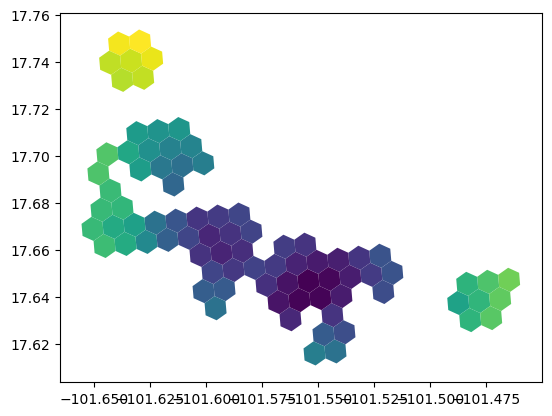

In [4]:
hex_gdf.plot('max_idx_15_min')

## Create Kepler

### Data treatment

In [5]:
columns_kepler = ['max_idx_15_min', 'max_escuelas', 'max_servicios comunitarios',
                      'max_comercio', 'max_entretenimiento','pobtot',
                  'dens_pobha','pobfem','pobmas','pob_0a14',
                      'pob_15a24', 'pob_25a59','p_60ymas']
for c in columns_kepler:
    if c == 'dens_pobha':
        hex_gdf[c] = hex_gdf[c].round(2)
        hex_gdf[c] = hex_gdf[c].astype(str) + ' (pob/ha)'
    else:
        hex_gdf[c] = hex_gdf[c].round().astype(int)
        
        if c != 'max_idx_15_min':
            
            if 'max' in c:
                hex_gdf[c] = hex_gdf[c].astype(str) + ' min'
            else:
                hex_gdf[c] = hex_gdf[c].astype(str)

In [6]:
rename_columns = {'max_escuelas':'Tiempo a escuelas',
                  'max_servicios comunitarios':'Tiempo a servicios comunitarios',
                  'max_comercio':'Tiempo a comercio',
                  'max_entretenimiento':'Tiempo a entretenimiento',
                  'pobtot':'Población total',
                  'dens_pobha':'Densidad de población',
                  'pobfem':'Población femenina',
                  'pobmas':'Población masculina',
                  'pob_0a14':'Población de 0 a 14 años',
                  'pob_15a24':'Población de 15 a 24 años',
                  'pob_25a59':'Población de 25 a 59 años',
                'p_60ymas':'Población de 60 años y más'}

### Missing amenity

In [7]:
lista_amenidades = ['max_preescolar','max_primaria',
                    'max_secundaria','max_salud','max_guarderías',
                    'max_asistencia social','max_alimentos','max_personal',
                    'max_farmacias','max_hogar','max_complementarios','max_social',
                    'max_actividad física', 'max_cultural']

missing_column_name = 'Equipamiento/servicio prioritario'

hex_gdf[missing_column_name] = 'No aplica'

idx = hex_gdf['max_idx_15_min']>15
hex_gdf.loc[idx,missing_column_name] = hex_gdf[lista_amenidades].idxmax(axis=1)

In [8]:
def missing_amenity(amenity_code):
    dict_names = {'max_preescolar':'Preescolar',
                 'max_primaria':'Primaria',
                 'max_secundaria':'Secundaria',
                  'max_guarderías':'Guardería',
                 'max_salud':'Salud - primer contacto',
                 'max_asistencia social':'Centro de asistencia social',
                 'max_alimentos':'Comercio de productos alimenticios',
                 'max_personal':'Comercio para el cuidado personal',
                 'max_farmacias':'Farmacia',
                 'max_hogar':'Comercio de artículos para el hogar',
                 'max_complementario':'Comercio barrial complementario',
                 'max_social':'Espacios de esparcimiento social',
                 'max_actividad física':'Espacios para la actividad física',
                 'max_cultural':'Espacios de esparcimiento cultural',
                 'No aplica':'No aplica'}
    return dict_names[amenity_code]

### Create configuration

In [9]:
column = 'max_idx_15_min'

config,config_idx = aup.kepler_config()

_name = 'Tiempo máximo a todos los servicios'
#_name = 'max_idx_15_min_2'

hex_gdf[_name] = hex_gdf[column].astype(str) + ' min'

bins = [0, 15, 30, 45, 60, hex_gdf[column].max()]
labels = ['0-15', '15-30', '30-45', '45-60', '60>']
hex_gdf[f'bins_{column}'] = pd.cut(
    hex_gdf[column], bins=bins, labels=labels, include_lowest=True)

config_idx["config"]["visState"]["layers"][0]["visualChannels"]["colorField"][
    "name"
] = f'bins_{column}'

config_idx["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"][
    "Análisis de hexágono"] = [_name, 'Tiempo a escuelas',
                  'Tiempo a servicios comunitarios','Tiempo a comercio',
                  'Tiempo a entretenimiento','           ',
                               'Población total','Densidad de población',
                               'Población femenina','Población masculina',
                               'Población de 0 a 14 años',
                               'Población de 15 a 24 años',
                               'Población de 25 a 59 años',
                               'Población de 60 años y más','            ',
                              missing_column_name]

#config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"][
#    "datos"]= [_name, 'max_escuelas', 'pobtot']

In [10]:
config_idx['config']['visState']['layers'][0]['config']['visConfig']['colorRange']['colors']

['#2C51BE', '#7A0DA6', '#CF1750', '#FD7900', '#FAE300']

In [11]:
config_idx['config']['visState']['layers'][0]['config']['visConfig']['colorRange']['colors'] = ['#FCD998','#F9A56A','#EC5F8F','#8B3569','#242258']

In [12]:
config_idx['config']['visState']['layers'][0]['config']['visConfig']['opacity']

0.35

In [13]:
config_idx['config']['visState']['layers'][0]['config']['visConfig']['opacity'] = 0.35

In [14]:
hex_kepler = hex_gdf[[_name, 'max_escuelas', 'max_servicios comunitarios',
                      'max_comercio', 'max_entretenimiento','pobtot',
                      'dens_pobha','pobfem','pobmas','pob_0a14',
                      'pob_15a24', 'pob_25a59','p_60ymas',missing_column_name,
                      'geometry',f'bins_{column}']] # .copy().to_json()

In [15]:
for c in rename_columns.keys():
    hex_kepler.rename(columns={c : rename_columns[c]}, inplace=True)

/tmp/ipykernel_4356/1188379886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_kepler.rename(columns={c : rename_columns[c]}, inplace=True)


In [16]:
hex_kepler[missing_column_name] = hex_kepler[missing_column_name].apply(missing_amenity)

/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [17]:
hex_kepler['           '] = '         '
hex_kepler['            '] = '          '

/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [18]:
hex_kepler.head(4)

,Tiempo máximo a todos los servicios,Tiempo a escuelas,Tiempo a servicios comunitarios,Tiempo a comercio,Tiempo a entretenimiento,Población total,Densidad de población,Población femenina,Población masculina,Población de 0 a 14 años,Población de 15 a 24 años,Población de 25 a 59 años,Población de 60 años y más,Equipamiento/servicio prioritario,geometry,bins_max_idx_15_min,,
0,50 min,50 min,31 min,22 min,23 min,213,2.5 (pob/ha),105,108,16,11,50,31,Primaria,"POLYGON ((-101.59660 17.64554, -101.59215 17.6...",45-60,,
1,107 min,105 min,107 min,9 min,106 min,678,7.95 (pob/ha),343,334,174,103,315,86,Centro de asistencia social,"POLYGON ((-101.62079 17.70540, -101.61634 17.7...",60>,,
2,99 min,99 min,75 min,48 min,74 min,9,0.1 (pob/ha),4,4,0,0,1,1,Secundaria,"POLYGON ((-101.62604 17.65834, -101.62159 17.6...",60>,,
3,144 min,97 min,92 min,20 min,144 min,684,8.03 (pob/ha),342,342,196,106,315,67,Espacios de esparcimiento cultural,"POLYGON ((-101.47364 17.64135, -101.46919 17.6...",60>,,


In [19]:
# hex_gdf["d"] = 0
longitude = hex_gdf.dissolve().geometry.centroid.x
latitude = hex_gdf.dissolve().geometry.centroid.y
config_idx["config"]["mapState"]["latitude"] = latitude[0]
config_idx["config"]["mapState"]["longitude"] = longitude[0]
# session = boto3.Session(profile_name="observatorio")
# dev_s3_client = session.client("s3")
# map_city = KeplerGl(height=800, data={"Análisis de ciudad": hex_kepler}, config=config_idx)
map_city = KeplerGl(height=800)
map_city.config = config_idx
map_city.add_data(hex_kepler, name='Análisis de hexágono')
map_city.save_to_html(file_name=f"{city.lower()}.html", read_only=True)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to zihuatanejo.html!


/tmp/ipykernel_4356/481004030.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_gdf.dissolve().geometry.centroid.x
/tmp/ipykernel_4356/481004030.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_gdf.dissolve().geometry.centroid.y
